## Task 3: Custom Exponential-like Distribution
A major advantage of a quantum walk over a classical one is the ability to generate arbitrary probability distributions. We can move beyond the 50/50 probability split by replacing the Hadamard gate with a Y-axis rotation gate, RY(θ).

This gate allows us to create a biased quantum coin. The probability of the ancilla qubit being measured as ∣1⟩ (a "right" turn) is directly controlled by the angle θ, according to the formula P(right)=sin
2
 (θ/2).

To create a distribution that resembles a decaying exponential curve, we engineer the walk to have a constant, low probability of turning right at every layer (e.g., p_right = 0.2). This forces most outcomes to have very few "right" turns, causing the final probabilities to be clustered at the low end and decay rapidly. The resulting distribution is a skewed binomial B(n, p=0.2), which provides an excellent discrete approximation of an exponential function.

In [ ]:
!pip install qiskit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 6.8 MB/s eta 0:00:00


In [ ]:
!pip install qiskit-aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 94.4 MB/s eta 0:00:00


Starting simulation...


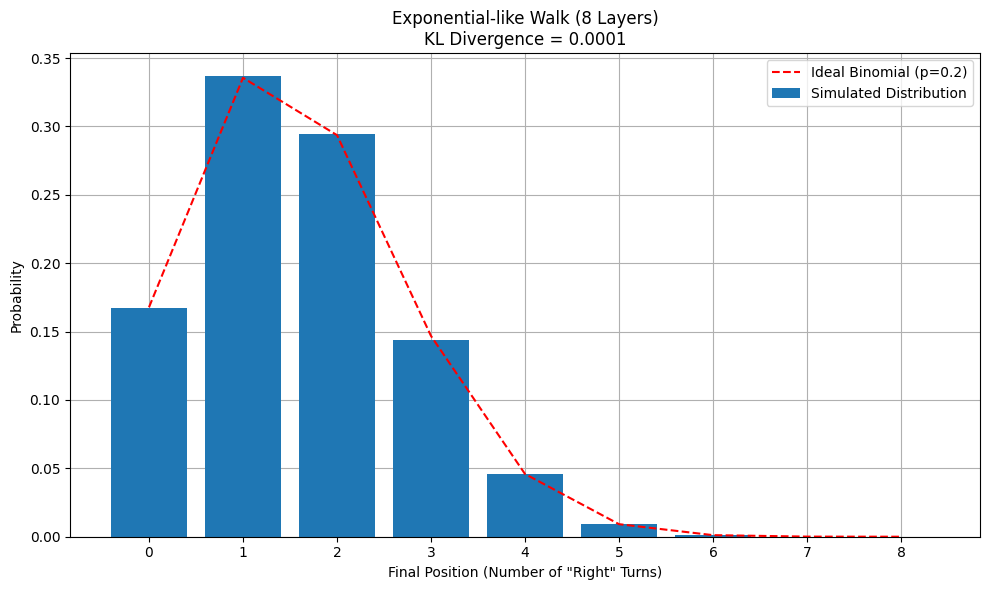

KL Divergence for Exponential-like Walk: 0.0001
Simulation completed in: 4.46 seconds


In [ ]:
# 1. IMPORT LIBRARIES
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from scipy.stats import binom, entropy
import time

# 2. DEFINE HELPER FUNCTIONS

def build_custom_walk_circuit(n_layers, theta):
    """
    Builds a quantum walk circuit with a custom, constant rotation angle.

    Args:
        n_layers (int): The number of layers for the walk.
        theta (float): The RY rotation angle to be applied at each layer.

    Returns:
        QuantumCircuit: The executable quantum circuit.
    """
    position_qubits = n_layers
    ancilla_qubit = n_layers

    qc = QuantumCircuit(position_qubits + 1, position_qubits)

    # For each layer, perform a biased 'coin flip'.
    for i in range(n_layers):
        # Apply an RY(theta) gate to the ancilla. This creates a biased
        # superposition, controlling the probability of turning left vs. right.
        qc.ry(theta, ancilla_qubit)

        # Update the position based on the coin's state.
        qc.cx(ancilla_qubit, i)

        # Reset the ancilla for the next independent layer.
        qc.reset(ancilla_qubit)

    qc.measure(range(position_qubits), range(position_qubits))
    return qc

def process_counts(counts_dict, n_layers):
    """
    Processes raw counts and converts them into a probability distribution.

    Args:
        counts_dict (dict): A dictionary of bitstring results and their counts.
        n_layers (int): The number of layers in the simulation.

    Returns:
        tuple: A tuple containing the outcome labels and the calculated probabilities.
    """
    positions = {i: 0 for i in range(n_layers + 1)}
    total_shots = sum(counts_dict.values())

    for bitstring, count in counts_dict.items():
        # The final position is the number of '1's in the bitstring.
        pos = bitstring.count('1')
        if pos in positions:
            positions[pos] += count

    outcomes = np.arange(n_layers + 1)
    # Convert the aggregated counts into a probability vector.
    probs = np.array([positions.get(i, 0) / total_shots for i in outcomes])
    return outcomes, probs

# 3. SETUP AND RUN THE SIMULATION

#Execute the Simulation and Track Time
print("Starting simulation...")

# Record the time right before execution
start_time = time.time()

# Define the number of layers for the walk.
n_layers = 8
# Use a high number of shots for good statistics.
shots = 16384

# --- Define the Custom Walk Parameters ---
# To create an exponential-like decay, we set a constant, low probability of turning right.
p_right = 0.2

# Calculate the single rotation angle 'theta' needed to achieve this probability.
# The formula is derived from P(right) = sin^2(theta/2).
theta = 2 * np.arcsin(np.sqrt(p_right))

# --- Build and Execute the Circuit ---
# Get the ideal, noiseless simulator.
ideal_sim = AerSimulator()

# Build the circuit with our custom angle.
exp_circuit = build_custom_walk_circuit(n_layers, theta)

# Execute the circuit.
result = ideal_sim.run(exp_circuit, shots=shots).result()
counts = result.get_counts()

# Record the time right after execution finishes
end_time = time.time()

# 4. PROCESS AND ANALYZE RESULTS

# Process the raw counts to get the simulated probability distribution.
outcomes, simulated_probs = process_counts(counts, n_layers)

# For comparison, calculate the ideal theoretical distribution, which is a
# Binomial distribution B(n, p) with p = p_right.
ideal_probs = binom.pmf(outcomes, n_layers, p_right)

# Calculate the KL Divergence to measure the accuracy of the simulation.
kl_div_exp = entropy(pk=simulated_probs, qk=ideal_probs)

# 5. PLOT THE DISTRIBUTION
plt.figure(figsize=(10, 6))
plt.bar(outcomes, simulated_probs, label='Simulated Distribution', zorder=2)
plt.plot(outcomes, ideal_probs, 'r--', label=f'Ideal Binomial (p={p_right})', zorder=3)

plt.title(f'Exponential-like Walk ({n_layers} Layers)\nKL Divergence = {kl_div_exp:.4f}')
plt.xlabel('Final Position (Number of "Right" Turns)')
plt.ylabel('Probability')
plt.xticks(outcomes)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Print the final metric.
print(f"KL Divergence for Exponential-like Walk: {kl_div_exp:.4f}")

# Calculate and Print the Duration
execution_time = end_time - start_time
print(f"Simulation completed in: {execution_time:.2f} seconds")